In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [2]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
url = r"train\\"

In [40]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((40,40)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [13]:
data = create_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:36<00:00, 90.52it/s]


In [4]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [5]:
X = (np.array([i[0] for i in data]))
Y = (np.array([i[1] for i in data]))

In [6]:
X = X /255.0

In [7]:
X.shape

(25000, 40, 40)

Text(0.5, 1.0, 'DOG')

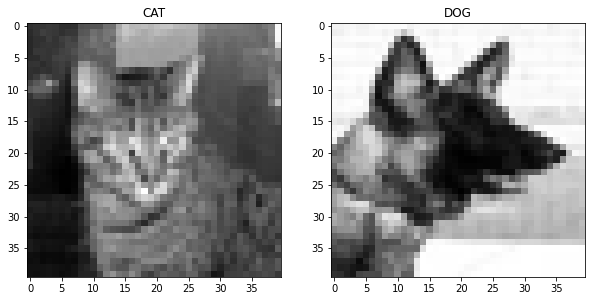

In [8]:
fig = plt.figure(figsize=(10, 7))
  
fig.add_subplot(1, 2, 1)
plt.imshow(X[1,:], cmap=plt.get_cmap('gray'))
plt.title("CAT")

fig.add_subplot(1, 2, 2)
plt.imshow(X[24999,:], cmap=plt.get_cmap('gray'))
plt.title("DOG")

In [9]:
X = X.reshape((25000, 40*40))
X.shape

(25000, 1600)

In [10]:
#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [14]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),2))

The DummyClassifier score is: 0.5


## *Models :*


### *Feature selection:*

In [52]:
scores = []
for i in range(400,1700,100):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train, test_size=0.1, random_state=42)
    KNN = KNeighborsClassifier().fit(X_train_new, y_train_new)
    y_pred = KNN.predict(X_val_new)
    accuracy = round(metrics.accuracy_score(y_val_new, y_pred),3)
    print("number of features : ", i, ", Accuracy:", accuracy)
    scores.append(accuracy)

number of features :  400 , Accuracy: 0.566
number of features :  500 , Accuracy: 0.584
number of features :  600 , Accuracy: 0.592
number of features :  700 , Accuracy: 0.597
number of features :  800 , Accuracy: 0.593
number of features :  900 , Accuracy: 0.59
number of features :  1000 , Accuracy: 0.591
number of features :  1100 , Accuracy: 0.586
number of features :  1200 , Accuracy: 0.583
number of features :  1300 , Accuracy: 0.584
number of features :  1400 , Accuracy: 0.589
number of features :  1500 , Accuracy: 0.595
number of features :  1600 , Accuracy: 0.594


> best accuracy with 700 features

In [13]:
X_train = SelectKBest(chi2, k=676).fit_transform(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

### *PCA:*

Text(0, 0.5, 'cumulative explained variance')

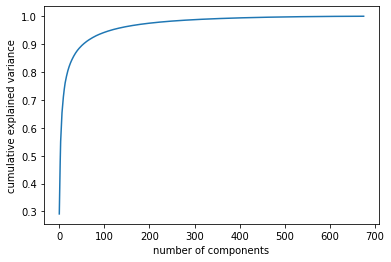

In [54]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [55]:
pca = PCA(n_components = 0.95,random_state=42)
X_reduced_train= pca.fit_transform(X_train)
X_reduced_test = pca.transform(X_val)

In [56]:
X_reduced_train.shape

(20250, 116)

### *XGBoost with PCA:*

In [60]:
%%time

XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_reduced_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_reduced_test)      
accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.615
CPU times: total: 57.2 s
Wall time: 10.5 s


### *Random Forest with PCA:*

In [61]:
%%time

RFC = RandomForestClassifier(random_state=42)
RFC.fit(X_reduced_train, y_train)
y_predict_RFC = RFC.predict(X_reduced_test)
accuracy = round(metrics.accuracy_score(y_val,y_predict_RFC),3)
print("Accuracy:", accuracy)

Accuracy: 0.594
CPU times: total: 17.9 s
Wall time: 17.9 s


### *VotingClassifier :*

In [62]:
lgb = lgb.LGBMClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()
svc  = SVC(kernel='rbf')
nb = GaussianNB()
GBC = GradientBoostingClassifier()
sgd = SGDClassifier(loss='modified_huber')
XGBClassifier = XGBClassifier(objective= 'binary:logistic',eval_metric='auc')

voting_clf = VotingClassifier(estimators=[('lgb', lgb),('GBC',GBC),('nb',nb),('svc', svc),('XGB', XGBClassifier),('rnd',rnd_clf),
                                          ('dt',dt_clf) ,('lr', log_clf), ('knn', knn_clf),('sgd', sgd)
                                          ],voting='hard',n_jobs=-1,)
voting_clf.fit(X_reduced_train, y_train)

for clf in (lgb,GBC, XGBClassifier, rnd_clf,svc , nb,sgd , dt_clf, log_clf, knn_clf, voting_clf):
    clf.fit(X_reduced_train, y_train)
    y_pred = clf.predict(X_reduced_test)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3))

LGBMClassifier 0.619
GradientBoostingClassifier 0.613
XGBClassifier 0.615
RandomForestClassifier 0.602
SVC 0.651
GaussianNB 0.586
SGDClassifier 0.56
DecisionTreeClassifier 0.528
LogisticRegression 0.574
KNeighborsClassifier 0.585
VotingClassifier 0.632


In [ ]:
# We didn't get impressive scores with PCA, we will try to get higher scores with clustering.

### *KMeans :*

In [74]:
pipeline = Pipeline([
 ("kmeans", KMeans(n_clusters=20)),
 ("XGB", XGBClassifier(objective="binary:logistic",eval_metric='auc'))])

pipeline.fit(X_train, y_train)
y_predict_pipe = pipeline.predict(X_val)
round(metrics.accuracy_score(y_val,y_predict_pipe),3)

0.576

In [73]:
pipeline = Pipeline([
 ("kmeans", KMeans(n_clusters=20)),
 ("Random Forest", RandomForestClassifier(random_state=42))])

pipeline.fit(X_train, y_train)
y_predict_pipe = pipeline.predict(X_val)
round(metrics.accuracy_score(y_val,y_predict_pipe),3)

0.561

### *Random Forest Classifier :*

In [75]:
%%time

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_val,y_pred_RF),3)
print("Accuracy:", accuracy)

Accuracy: 0.639
CPU times: total: 29 s
Wall time: 29.1 s


### *XGB Classifier:*

In [76]:
%%time

XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB),3)
print("Accuracy:", accuracy)

Accuracy: 0.645
CPU times: total: 2min 2s
Wall time: 21.8 s


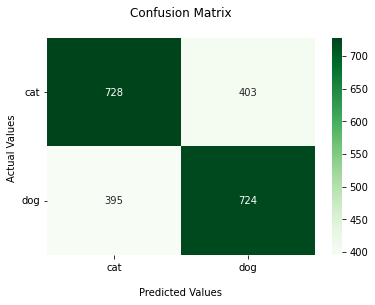

In [78]:
cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

### *AdaBoost Classifier:*

In [79]:
%%time

AdB =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,
                          algorithm="SAMME.R", learning_rate=0.5)
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.604
CPU times: total: 3min 22s
Wall time: 3min 26s


### *SVC:*

In [80]:
svc  = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)

Accuracy: 0.644


### *Gradient Boosting Classifier:*

In [95]:
GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))    

      Iter       Train Loss   Remaining Time 
         1           1.3794            9.62m
         2           1.3730            9.25m
         3           1.3673            8.89m
         4           1.3623            8.66m
         5           1.3576            8.54m
         6           1.3534            8.90m
         7           1.3491            8.92m
         8           1.3444            8.91m
         9           1.3406            9.00m
        10           1.3367            9.05m
        20           1.3064            8.53m
        30           1.2824            7.47m
        40           1.2652            6.50m
        50           1.2492            5.50m
        60           1.2341            4.41m
        70           1.2202            3.30m
        80           1.2071            2.19m
        90           1.1947            1.10m
       100           1.1836            0.00s
Accuracy: 0.649


### Hyperparameter Tuning: 

In [ ]:
#Searching for better performance out of the models with RandomizedSearch

In [ ]:
param = {'C': [1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
 
random_SVC = RandomizedSearchCV(SVC(), param, verbose = 3, cv=2,n_iter=5)

random_SVC.fit(X_train, y_train)
y_pred_SVC_random = random_SVC.predict(X_val)
print ("Accuracy Score = ",round(metrics.accuracy_score(y_val,y_pred_SVC_random),3))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END .........C=10, gamma=1, kernel=rbf;, score=0.503 total time= 2.5min
[CV 2/2] END .........C=10, gamma=1, kernel=rbf;, score=0.502 total time= 2.4min
[CV 1/2] END ........C=100, gamma=1, kernel=rbf;, score=0.503 total time= 2.3min
[CV 2/2] END ........C=100, gamma=1, kernel=rbf;, score=0.502 total time= 2.3min
[CV 1/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.624 total time= 1.5min
[CV 2/2] END ........C=1, gamma=0.1, kernel=rbf;, score=0.622 total time= 1.5min
[CV 1/2] END .......C=10, gamma=0.1, kernel=rbf;, score=0.619 total time= 2.6min


### testing the final models
- XGB
- Voting Classifier
- SVC

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [ ]:
selector = SelectKBest(chi2, k=676)
X_train = selector.fit_transform(X_train,y_train)
X_test =selector.transform(X_test)

In [ ]:
%%time

XGB = XGBClassifier(objective="binary:logistic",random_state=42)
XGB.fit(X_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

In [25]:
%%time
lgb = lgb.LGBMClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()
svc  = SVC(kernel='rbf')
nb = GaussianNB()
GBC = GradientBoostingClassifier()
sgd = SGDClassifier(loss='modified_huber')
XGBClassifier = XGBClassifier(objective= 'binary:logistic',eval_metric='auc')

voting_clf = VotingClassifier(estimators=[('lgb', lgb),('GBC',GBC),('nb',nb),('svc', svc),('XGB', XGBClassifier),('rnd',rnd_clf),
                                          ('dt',dt_clf) ,('lr', log_clf), ('knn', knn_clf),('sgd', sgd)
                                          ],voting='hard',n_jobs=-1,)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))


Accuracy: 0.658
CPU times: total: 6min 12s
Wall time: 1min 1s


In [26]:
%%time
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("Accuracy:", accuracy)

Accuracy: 0.652
CPU times: total: 17min 26s
Wall time: 33min 43s


In [27]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_reduced_train = pca.transform(X_train)
X_reduced_test = pca.transform(X_test)

In [28]:
%%time
XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_reduced_train, y_train,eval_metric='auc')
y_pred = XGB.predict(X_reduced_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.627
CPU times: total: 9min 51s
Wall time: 1min 18s


## *The best model accuracy : 0.676*